## Plotting benchmark results for PrivacyGLUE

PrivacyGLUE is a Natural Language Understanding benchmark which determines the performance of models in the privacy domain by fine-tuning, testing and measuring their performance on tasks related to analysis of privacy documents.
In this notebook we visualize the benchmark performance of 5 selected transformer-based models.

In [199]:
import json
import os

import pandas as pd
import matplotlib
import scipy
from plotnine import (
    aes,
    element_blank,
    element_text,
    element_rect,
    facet_wrap,
    geom_col,
    geom_errorbar,
    geom_pointrange,
    geom_text,
    geom_path,
    ggplot,
    guides,
    guide_legend,
    labs,
    position_dodge,
    scale_color_manual,
    scale_fill_continuous,
    theme,
    theme_bw,
)

%matplotlib inline
matplotlib.rc("text", usetex=True)

First we get the metrics from the runs directory and arange them in a pandas dataframe.

In [171]:
# declare global variables
MODELS = {
    "bert_base_uncased": "BERT",
    "roberta_base":"RoBERTa",
    "nlpaueb_legal_bert_base_uncased": "Legal-BERT",
    "saibo_legal_roberta_base": "Legal-RoBERTa",
    "mukund_privbert": "PrivBERT"
}

TASKS= {
    "opp_115": "\\textbf{OPP-115}",
    "piextract": "\\textbf{PI-Extract}",
    "policy_detection": "\\textbf{Policy-Detection}",
    "policy_ie_a": "\\textbf{PolicyIE-A}",
    "policy_ie_b": "\\textbf{PolicyIE-B}",
    "policy_qa": "\\textbf{PolicyQA}",
    "privacy_qa": "\\textbf{PrivacyQA}"
}

METRICS = {
    "macro_f1": "Macro F$_1$",
    "micro_f1": "Micro F$_1$",
    "sample_f1": "Sample F$_1$",
    "exact_match": "Exact Match"
}


# collect all data into list of dictionaries
all_results = []
for model in MODELS:
    with open(os.path.join("..", "runs", model, 
                           "benchmark_summary.json"), "r") as summary_file:
        model_results = json.load(summary_file)
        for task, task_dict in model_results.items():
            row_dict = {"mean": [], "std": [], "metric": [], "samples": []}
            row_dict["model_name"]= MODELS[model]
            row_dict["task"] = TASKS[task]
            row_dict["num_samples"] = task_dict["num_samples"]
            for index, metric in enumerate(task_dict["metrics"]):
                if metric in ["macro_f1", "micro_f1", "sample_f1", "exact_match"]:
                    row_dict["metric"].append(METRICS[metric])
                    row_dict["samples"].append(task_dict["samples"][index])
                    for statistic in ["mean", "std"]:
                        multiplier = 100 if task != "policy_qa" else 1
                        row_dict[statistic].append(task_dict[statistic][index] * multiplier)
            all_results.append(row_dict)

# convert into pandas dataframe
all_results = pd.DataFrame(all_results).apply(pd.Series.explode).reset_index(drop=True).infer_objects()
all_results = all_results.assign(metric = pd.Categorical(all_results["metric"], list(METRICS.values())))
all_results = all_results.assign(model_name = pd.Categorical(all_results["model_name"], list(MODELS.values())))

In [180]:
# define significance test
def test_significance(group):
    group["priv_bert_significance"] = ""
    priv_bert_samples = group.loc[group["model_name"] == "PrivBERT"]["samples"].item()
    significance_collection = {0.05: [], 0.01: [], 0.001: []}
    for index, row in group.iterrows():
        if row["model_name"] != "PrivBERT":
            other_model_samples = row["samples"]
            test = scipy.stats.mannwhitneyu(priv_bert_samples, other_model_samples,
                                            alternative="greater")
            significance_collection[0.05].append(test.pvalue <= 0.05 and test.statistic >= 0)
            significance_collection[0.01].append(test.pvalue <= 0.01 and test.statistic >= 0)
            significance_collection[0.001].append(test.pvalue <= 0.001 and test.statistic >= 0)

    if all(significance_collection[0.001]) and significance_collection[0.001]:
        group.loc[group["model_name"] == "PrivBERT", "priv_bert_significance"] = "***"
    elif all(significance_collection[0.01]) and significance_collection[0.01]:
        group.loc[group["model_name"] == "PrivBERT", "priv_bert_significance"] = "**"
    elif all(significance_collection[0.05]) and significance_collection[0.05]:
        group.loc[group["model_name"] == "PrivBERT", "priv_bert_significance"] = "*"

    return group

In [181]:
# apply significance testing
all_results = all_results.groupby(["task", "metric"], group_keys=False).apply(test_significance)

In [182]:
all_results

,mean,std,metric,samples,model_name,task,num_samples,priv_bert_significance
0,78.441183,0.638842,Macro F$_1$,"[0.7948790738914613, 0.7730874281098047, 0.785...",BERT,\textbf{OPP-115},10,
1,83.993594,0.464772,Micro F$_1$,"[0.8478802992518704, 0.8295102293862369, 0.841...",BERT,\textbf{OPP-115},10,
2,60.026523,2.664304,Macro F$_1$,"[0.5613634788634789, 0.6198649783651831, 0.618...",BERT,\textbf{PI-Extract},10,
3,60.026523,2.664304,Micro F$_1$,"[0.5613634788634789, 0.6198649783651831, 0.618...",BERT,\textbf{PI-Extract},10,
4,85.327072,1.837340,Macro F$_1$,"[0.8697583182205115, 0.8419790104947527, 0.831...",BERT,\textbf{Policy-Detection},10,
...,...,...,...,...,...,...,...,...
65,55.727150,1.345103,Micro F$_1$,"[0.5634681529823189, 0.5284266758685046, 0.577...",PrivBERT,\textbf{PolicyIE-B},10,*
66,59.263923,0.530525,Sample F$_1$,"[58.71148563258109, 59.26341432459493, 59.1925...",PrivBERT,\textbf{PolicyQA},10,***
67,31.380058,0.630032,Exact Match,"[30.804431599229286, 31.671483622350674, 31.02...",PrivBERT,\textbf{PolicyQA},10,***
68,55.295588,0.553319,Macro F$_1$,"[0.5521272515621429, 0.5462078472309376, 0.557...",PrivBERT,\textbf{PrivacyQA},10,**


Then we visualize all our metrics:

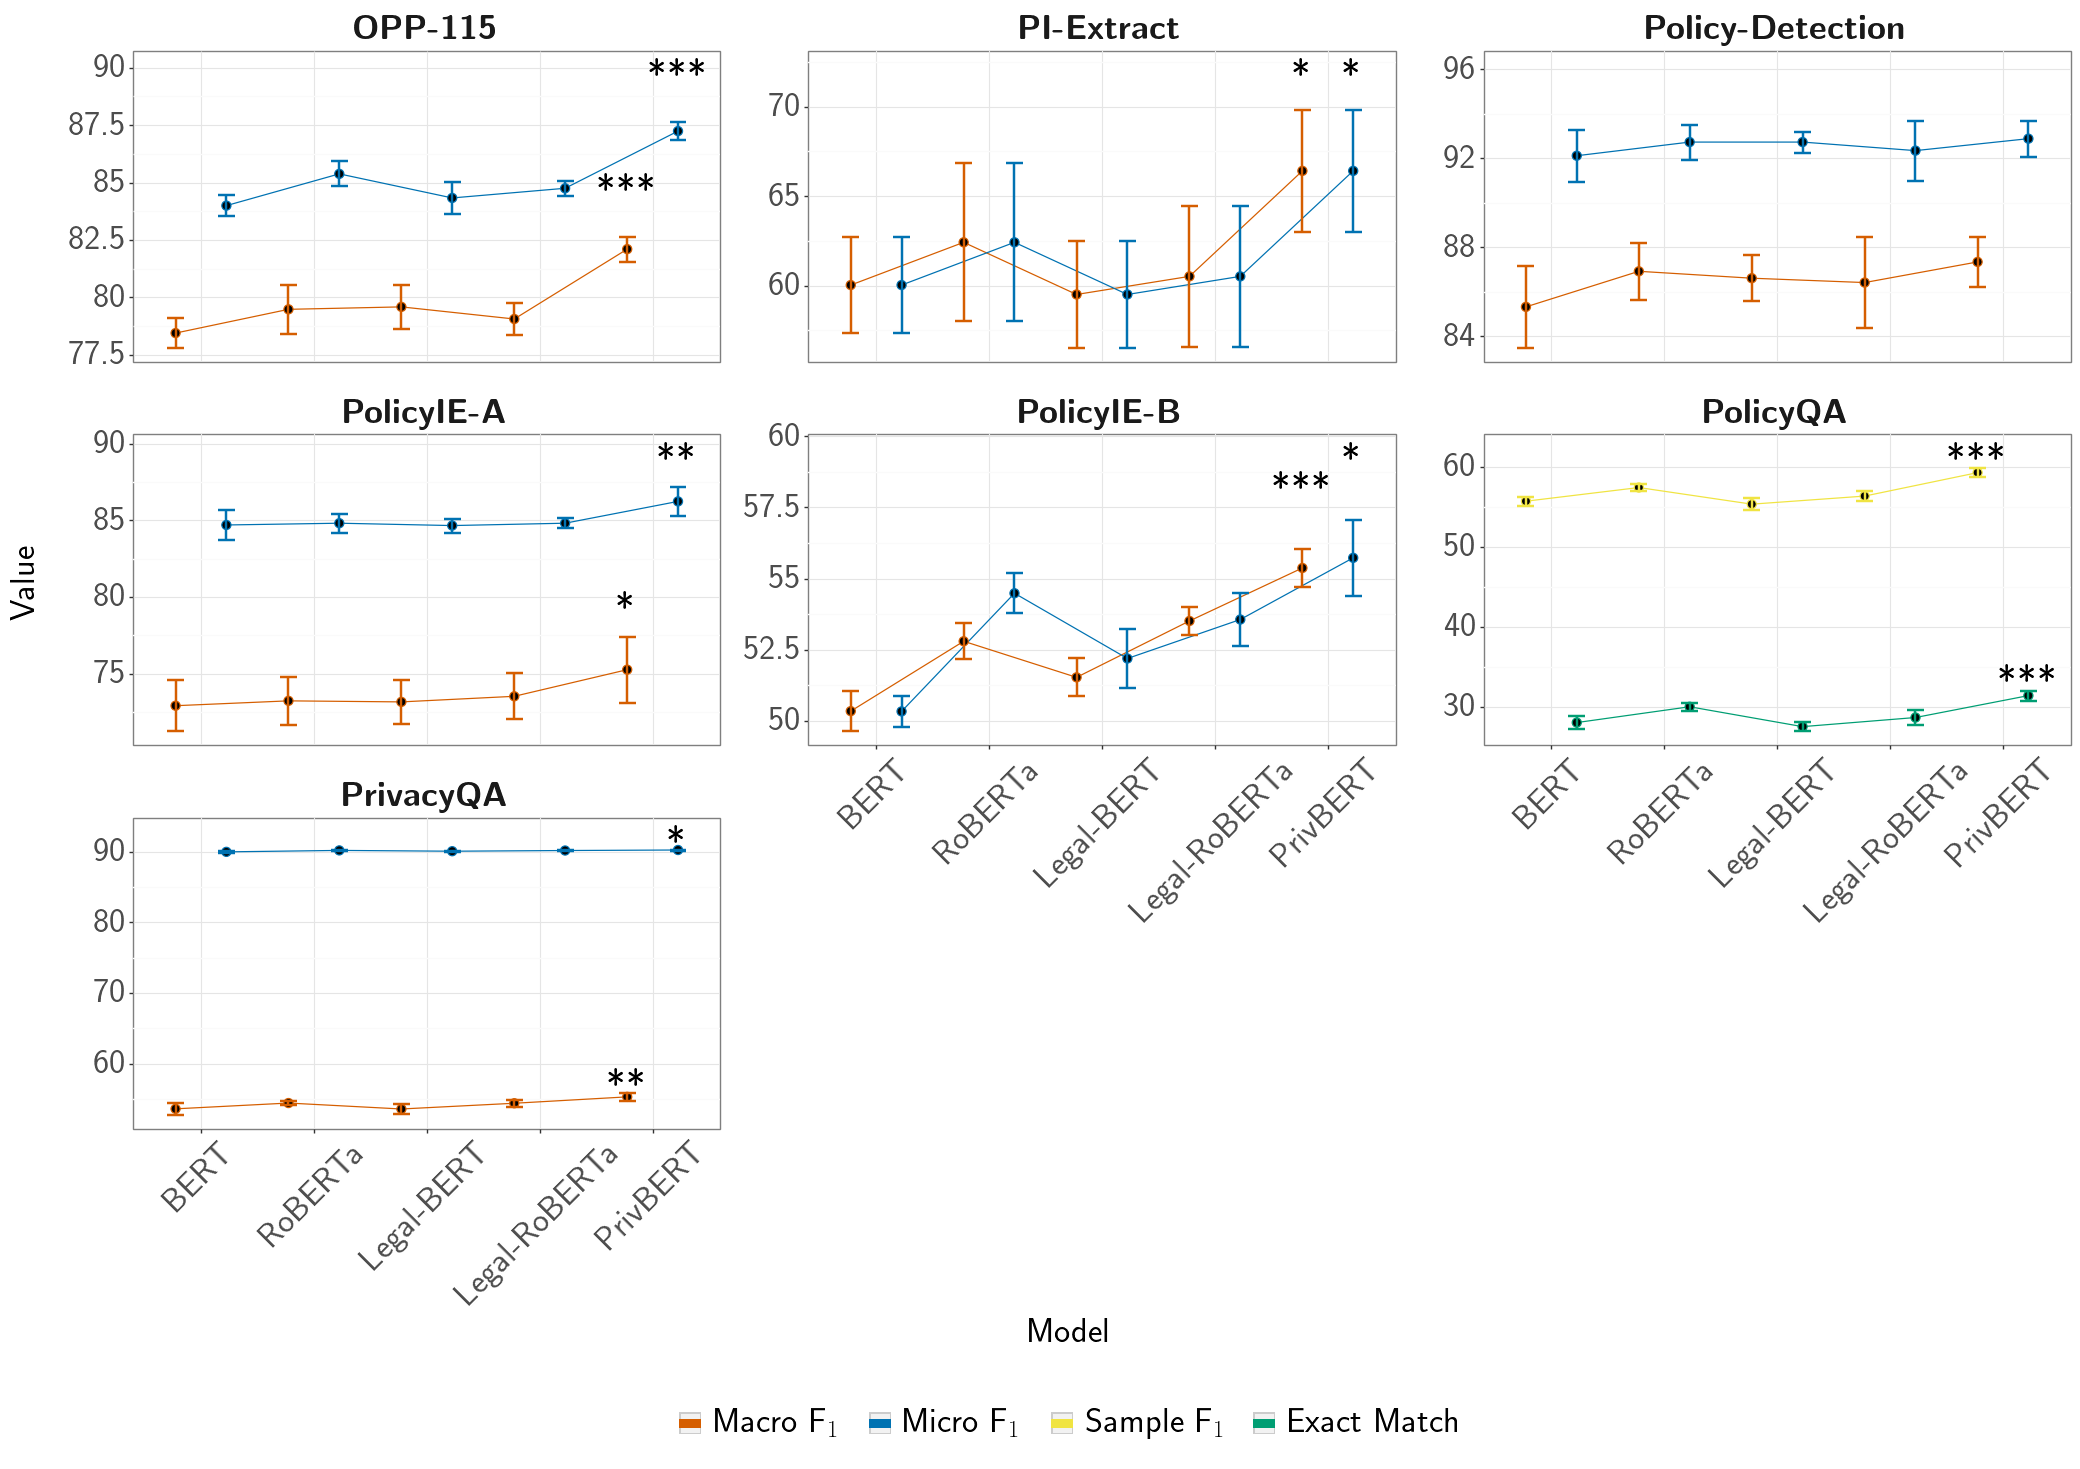

In [204]:
# plot ggplot object
(
    ggplot(all_results, aes(x="model_name", y="mean", group="metric", color="metric"))
    + geom_line(position=position_dodge(width=0.9))
    + geom_pointrange(mapping=aes(ymin="mean + std", ymax="mean - std"),
                      position=position_dodge(width=0.9), size=0.8, fill="black",
                      show_legend=False)
    + geom_errorbar(mapping=aes(ymin="mean + std", ymax="mean - std"),
                    position=position_dodge(width=0.9), width=0.3, size=1)
    + geom_text(mapping=aes(label="priv_bert_significance", y = "mean + std + 2.5"),
                position=position_dodge(width=0.9), size=30, color="black")
    + facet_wrap("task", ncol=3, scales="free_y")
    + theme_bw()
    + theme(axis_text_x=element_text(angle = 45),
            axis_title_y=element_text(margin={"r": 20}),
            figure_size=(25, 14), panel_spacing_y=0.3,
            text=element_text(size=25), legend_text=element_text(margin={"l": 10}),
            legend_position=(0.5, -0.1), legend_direction="horizontal", legend_title=element_blank(),
            legend_entry_spacing=20, strip_background=element_blank(), subplots_adjust={"wspace": 0.15})
    + scale_color_manual(values=list(reversed(["#009e73", "#f0e442", "#0072b2", "#d55e00"])))
    + labs(x="Model", y="Value")
    + guides(color=guide_legend(override_aes={"size": 3}))
).draw();